<a href="https://colab.research.google.com/github/thisissepehr/image-classification-deep-models/blob/main/VGG16_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
print(torch.__version__)
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import cv2

from torchvision import datasets
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary


1.11.0+cu113


In [3]:
# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other

DEVICE = 'cuda:0'
# print(DEVICE)
GRAYSCALE = True

In [4]:
def scale(data):
        (images,y) = data
        img_rgb = []
        for img in images:
                img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA) 
                img_rgb.append(img)
        img_rgb = np.asanyarray(img_rgb)
        return img_rgb,y

def rgb(data):
        (images,y) = data
        img_rgb = []
        for img in images:
                img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
                #img_rgb.append(np.asarray(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)))
                img_rgb.append(np.asarray(np.dstack((img, img, img)), dtype=np.uint8))
        img_rgb = np.asanyarray(img_rgb)
        return img_rgb,y

In [5]:
transform_train = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

transform_test = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])


train_ds = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transform_train,
                               download=True)
train_set, val_set = torch.utils.data.random_split(train_ds, [50000, 10000])

test_ds = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transform_test)
print(test_ds[0])


train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                      shuffle = False)


val_loader = DataLoader(dataset=val_set,
                          batch_size=BATCH_SIZE,
                      shuffle = False)

test_loader = DataLoader(dataset=test_ds,
                     batch_size=BATCH_SIZE,
                     shuffle = False)

# Checking the dataset
images, labels = next(iter(train_loader))  
print('Image batch dimensions:', images.shape)
print('Image label dimensions:', labels.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 7)
Image batch dimensions: torch.Size([64, 1, 64, 64])
Image label dimensions: torch.Size([64])


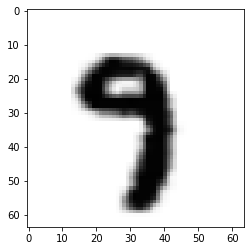

In [6]:
features, targets = next(iter(train_loader))

features = features
targets = targets

    
nhwc_img = np.transpose(features[2], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')

In [7]:
#Model
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(2048, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        probas = F.softmax(out, dim=1)
        return out, probas

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
torch.manual_seed(RANDOM_SEED)

In [8]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_predictions, counter = 0, 0
        for _, (img, label) in enumerate(data_loader):
            img = img.to(device)
            label = label.float().to(device)
            logits = model(img)
            _, predicted_label = torch.max(logits[1], 1)
            counter += label.size(0)
            correct_predictions += (predicted_label == label).sum()
    return correct_predictions.float()/counter * 100


In [9]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VGG("VGG16")
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
model = model.to(DEVICE)


In [10]:
def train(model, num_epochs, train_loader,valid_loader, test_loader, optimizer):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits[1], targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            train_acc = accuracy(model, train_loader, device=DEVICE)
            valid_acc = accuracy(model, valid_loader, device=DEVICE)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    test_acc = accuracy(model, test_loader, device=DEVICE)
    print(f'Test accuracy {test_acc :.2f}%')

In [11]:
train(model= model,
      num_epochs = NUM_EPOCHS,
      train_loader= train_loader,
      valid_loader = val_loader,
      test_loader = test_loader,
      optimizer = optimizer)

Epoch: 001/010 | Train: 83.53% | Validation: 83.65%
Time elapsed: 1.51 min
Epoch: 002/010 | Train: 84.70% | Validation: 85.03%
Time elapsed: 3.07 min


KeyboardInterrupt: ignored

In [ ]:
def get_prediction(x, model):
    model.to('cpu') # prepares model for predicting
    probabilities = torch.softmax(model(x)[1], dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [ ]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
    x, y = batch
    true_y.extend(y)
    #print(type(x))
    preds, probs = get_prediction(x, model)
    pred_y.extend(preds.cpu())

In [ ]:
print(classification_report(true_y, pred_y, digits=3))

In [ ]:
features, targets = next(iter(test_loader))    
nhwc_img = np.transpose(features[3], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')

In [ ]:
predicted, probability = get_prediction(features[3, None], model)
print('Predicted:', predicted)
print('Probability:', probability[0][predicted]*100)

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    fig, ax = plt.subplots(figsize=(16,16))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(true_y, pred_y)
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm,labels) 